In [1]:
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('mfeatures.csv').drop(columns='target')
model = pickle.load(open('cbc.pkl', 'rb'))

In [3]:
proba = model.predict_proba(df.fillna(-999999))[:, 1]

In [4]:
df['proba'] = proba

## Для расчета порогов предполагаются некоторые допущения:
* Максимальная сумма 500 у.е.
* Первая пороговая сумма 300 у.е.
* Вторая пороговая сумма 150 у.е.
* Банк готов потерять 10 у.е. по займу
* Процентная ставка по каждому займу 10%
* Если ожидаемые потери группы по одному из факторов больше на 10 у.е. или в интервале от +5 у.е. до +10 у.е. от потерь всей выборки, то клиенту назначается 150 у.е. или 300 у.е. соотвественно, при условие, что PD клиента меньше основного порога

### Расчет порогов
По клиенту считается ожидаемые убытки и процентный доход, далее выбирается клиент с максимальным процентным доходом и по ожидаемому убытку по нему считается порог \
\
$Ожидаемые\:убытки = сумма\:заема * вероятность\:дефолта$ \
$Процентный\:доход = (1 - вероятность\:дефолта) * сумма\:заема * процентная\:ставка - ожидаемые\:убытки$
$Порог\:одобрения = (одобренный\:риск + ожидаемые\:убытки\:по\:клиенту\:с\:наибольшим\:процентным\:доходом)\:/\:сумма\:заема$

In [5]:
def calc_proba(df, amount, interest_rate=0.1, risk=10):
    df = df.copy()
    df['amount'] = amount
    df['expected_loss'] = df['amount'] * df['proba']
    df['interest_income'] = (1 - df['proba']) * amount * interest_rate - df['expected_loss']
    max_proffit_idx = df['interest_income'].sort_values(ascending=False).index[0]
    expected_loss = df['expected_loss'][max_proffit_idx]
    proba = (risk + expected_loss) / amount
    print(f'Значение порога для суммы {amount}: {round(proba, 3)}, ожидаемые потери: {expected_loss}')
    return proba

In [6]:
proba500 = calc_proba(df, 500)

Значение порога для суммы 500: 0.056, ожидаемые потери: 18.191345625426376


In [7]:
proba300 = calc_proba(df.loc[df['proba'] >= proba500], 300)

Значение порога для суммы 300: 0.09, ожидаемые потери: 16.914829465928072


In [8]:
proba150 = calc_proba(df.loc[df['proba'] >= proba300], 150)

Значение порога для суммы 150: 0.156, ожидаемые потери: 13.457597856451537


### Расчет прогов для фичей

In [9]:
def calc_expected_loss(category, col, df, amount):
    for i in range(len(category) - 1):
        temp_df = df.loc[(df[col] <= category[i + 1]) & (df[col] > category[i])]
        calc_proba(temp_df, amount)
        print(category[i + 1])

#### age

<AxesSubplot: xlabel='age', ylabel='Density'>

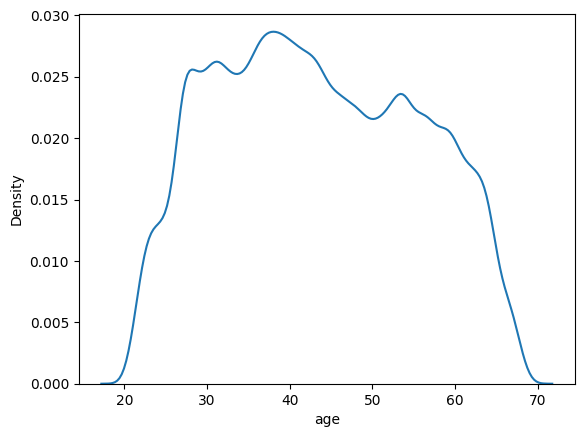

In [10]:
sns.kdeplot(df['age'])

In [11]:
age_category = [0, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
calc_expected_loss(age_category, 'age', df, 500)

Значение порога для суммы 500: 0.069, ожидаемые потери: 24.329794557069658
25
Значение порога для суммы 500: 0.068, ожидаемые потери: 23.97428589654919
30
Значение порога для суммы 500: 0.065, ожидаемые потери: 22.437432062445257
35
Значение порога для суммы 500: 0.062, ожидаемые потери: 21.105897231188596
40
Значение порога для суммы 500: 0.059, ожидаемые потери: 19.362338265146185
45
Значение порога для суммы 500: 0.06, ожидаемые потери: 19.984473406704986
50
Значение порога для суммы 500: 0.06, ожидаемые потери: 19.773356551567584
55
Значение порога для суммы 500: 0.056, ожидаемые потери: 18.191345625426376
60
Значение порога для суммы 500: 0.057, ожидаемые потери: 18.30472706945861
65
Значение порога для суммы 500: 0.064, ожидаемые потери: 22.194552440573883
70


#### weighted_ext_scores

<AxesSubplot: xlabel='weighted_ext_scores', ylabel='Density'>

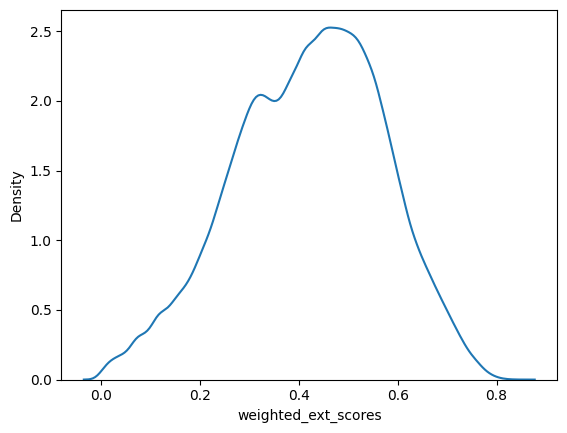

In [12]:
sns.kdeplot(df['weighted_ext_scores'])

In [13]:
weighted_ext_scores_category = [0, 0.2, 0.4, 0.6, 1]
calc_expected_loss(weighted_ext_scores_category, 'weighted_ext_scores', df, 500)

Значение порога для суммы 500: 0.108, ожидаемые потери: 44.078030770424974
0.2
Значение порога для суммы 500: 0.074, ожидаемые потери: 26.788225536102694
0.4
Значение порога для суммы 500: 0.056, ожидаемые потери: 18.191345625426376
0.6
Значение порога для суммы 500: 0.059, ожидаемые потери: 19.744559778070595
1
